In [144]:
import sys
import ROOT as r
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from array import array as arr

%jsroot on

In [132]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcV4/mc.root", "READ")

fData = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/dataV4/data.root", "READ")

fCosmic = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/offbeamData/offbeamV2.root", "READ")

In [133]:
c1 = r.TCanvas("c1", "c1", 800, 600)

h_energy  = fin.Get('cosmic/seqPlots/seqShwContained_rShowerEnergy')
h_dedx = fin.Get('cosmic/seqPlots/seqShwContained_rShowerDeDx')

# h_dedx.Draw()
# c1.Draw()

print(h_energy.GetEntries(), h_dedx.GetEntries())
print(h_energy.Integral(0, h_energy.GetNbinsX()+1), h_dedx.Integral(0, h_dedx.GetNbinsX()+1))
print(h_energy.Integral(), h_dedx.Integral())

h_tnue = fin.Get('allEvents/seqPlots/seqShowerDensity_tNueEnergy')
print(h_tnue.Integral(0, h_tnue.GetNbinsX()+1), h_tnue.GetEntries())

t = fin.Get('t_sel/t_sel')
entries = t.GetEntries()
pot = fin.Get('t_sel').Get('POT').GetBinContent(1)

scale = 3e20 / round(pot, 2)
print(f"Entries: {entries}, POT: {pot}, Scale: {scale}, Scaled Entries: {entries*scale}")



2878.0 2878.0
17385.32645499341 17385.326454993414
17354.92874974959 15741.849433641835
22558.22049424657 3735.0
Entries: 3735, POT: 7.945126166046788e+20, Scale: 0.3775899762070982, Scaled Entries: 1410.2985611335118


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [134]:
#determine scaling

plotScale = 3e20 #scale used when making plots (mistake when making plots)

t_data = fData.Get('t_raw')
t_mc = fin.Get('t_raw')
t_cosmic = fCosmic.Get('t_raw')

pot_data = t_data.Get('POT').GetBinContent(1)
pot_mc = t_mc.Get('POT').GetBinContent(1)
pot_cosmic = t_cosmic.Get('POT').GetBinContent(1)

t_data = fData.Get('t_raw').Get('Livetime').GetBinContent(1)
t_mc = fin.Get('t_raw').Get('Livetime').GetBinContent(1)
t_cosmic = fCosmic.Get('t_raw').Get('Livetime').GetBinContent(1)

print("POT data: ", pot_data, "Livetime: ", t_data)
print("POT MC: ", pot_mc, "Livetime: ", t_mc)
print("POT cosmic: ", pot_cosmic, "Livetime: ", t_cosmic)

scale_mc = (plotScale / pot_mc)
scale_data = (plotScale / pot_data)

print("MC scale: ", scale_mc)
print("Data scale: ", scale_data)

pot_data = pot_data * scale_data
pot_mc = pot_mc * scale_mc

t_data = t_data * scale_data
t_mc = t_mc * scale_mc

diff_time = t_data - t_mc
scale_cosmic = diff_time / t_cosmic
print("Time difference data - mc: ", diff_time / 16)
print("Cosmic data time: ", t_cosmic)

#mc and data already scaled by caf
scale_data = 1 / 16
scale_mc = 1 / 16
scale_cosmic = scale_cosmic / (300) #not sure why cosmic data shows factor 300 scaling in hists

print("Scaled POT data: ", pot_data, "Scaled Livetime: ", t_data, "Scale: ", scale_data)
print("Scaled POT MC: ", pot_mc, "Scaled Livetime: ", t_mc, "Scale: ", scale_mc)
print("Scaled POT cosmic: ", pot_cosmic, "Scaled Livetime: ", t_cosmic*scale_cosmic, "Scale: ", scale_cosmic)


POT data:  2.6894775683865965e+19 Livetime:  582944.0
POT MC:  7.945126166046788e+20 Livetime:  1531900.0
POT cosmic:  0.0 Livetime:  571993.0
MC scale:  0.3775899762070982
Data scale:  11.154582716225011
Time difference data - mc:  370254.1863984637
Cosmic data time:  571993.0
Scaled POT data:  3e+20 Scaled Livetime:  6502497.066927073 Scale:  0.0625
Scaled POT MC:  3e+20 Scaled Livetime:  578430.0845516537 Scale:  0.0625
Scaled POT cosmic:  0.0 Scaled Livetime:  19746.889941251397 Scale:  0.03452295734607136


In [135]:
class histInfo:
    def __init__(self, name, hist, data=False):
        self.name = name
        self.hist = hist
        self.data = data
        self.integral = 0
        self.calculateIntegral()
    
    def calculateIntegral(self):
        # if self.name.split('_')[-1].startswith('t') and self.data: 
        #     self.integral = 0
        # else:
        if self.hist.InheritsFrom("TH2"):
            self.integral = self.hist.Integral(0, self.hist.GetNbinsX()+1, 0, self.hist.GetNbinsY()+1)
        elif self.hist.InheritsFrom("TH1"):
            self.integral = self.hist.Integral(0, self.hist.GetNbinsX()+1)
        else:
            self.integral = -1    

class histList:
    def __init__(self):
        self.histDict = {}
        self.histList = []
    
    def add(self, histInfo_obj):
        self.histList.append(histInfo_obj)
        self.histDict[histInfo_obj.name] = histInfo_obj
    
    def get_dict(self):
        return self.histDict 
    
    def values(self):
        return self.histDict.values()  
    
    def keys(self):
        return self.histDict.keys()  
    
    def __getitem__(self, key):
        return self.histDict[key]  
    
    def scale(self, scale):
        for h in self.histList:
            #print("scaling ", h.name)
            if isinstance(h.hist, r.TH1):
                h.hist.Scale(scale)
                h.calculateIntegral()
                #print(h.name, h.integral)

def getHistList(fin, dirName, skip=None, scale=None, data=False):
    dir = fin.GetDirectory(dirName)
    keys = dir.GetListOfKeys()
    mylist = histList()
    for k in keys:
        obj = k.ReadObj()
        if obj.InheritsFrom("TH1"):
            if skip is not None and skip in k.GetName():
                continue
            obj.SetName(k.GetName())
            mylist.add(histInfo(k.GetName(), obj, data))
    if scale is not None:
        #print("scaling hists by", scale)
        mylist.scale(scale)
    return mylist

def mergeHists(l1, l2):
    for (k1, h1) in l1.histDict.items():
        for (k2, h2) in l2.histDict.items():
            if k1 == k2:
                h1.hist.Add(h2.hist)
                h1.integral += h2.integral


def makeCombinedPlots(plotDict, outputFile, outputDir, totalEvents, labels, pType, df=None, stacked=False, data=None, text=None, colors=None):

    outputFile.mkdir(outputDir)
    c1 = r.TCanvas("c1", "c1", 800, 800)
    l = r.TLegend(0.7, 0.7, 0.9, 0.9)
    
    # Get the first dictionary to access its keys
    first_dict = next(iter(plotDict.values()))

    drawAll = True
    plotRatioGlobal = True

    if stacked and pType == 'seq': drawAll = False

    if not stacked and plotDict.keys().__len__() > 2:
        print("Warning: can only plot ratio for 2 plot types when not stacked")
        plotRatioGlobal = False 
    
    #loop over the plots
    for i, key in enumerate(first_dict.keys()):
        #print(i, key)

        #reset everything
        l.Clear()
        c1.Clear()
        drawS = "hist"
        maxY = -1

        plotRatio = plotRatioGlobal
        if key.split('_')[-1].startswith('t') or 'residual' in key.lower() or data is None:
            plotRatio = False

        #only plot stacked plots if they are the final selections
        if stacked:
            #if 'InteractionMode' in key or 'MaxShowerEnergySlice' in key: continue
            if 'MaxShowerEnergySlice' in key: continue
            if (i+1) % len(labels) != 0 and not drawAll: continue
            h_stack = r.THStack("h_stack", "")
            # scale = 1.0
            # if data is not None:
            #     mcI = 0
            #     dataI = data[key].integral
            #     for p in plotDict.values():
            #         mcI += p[key].integral
            #     scale = dataI / mcI
            
        #make ratio plot if data exists
        if plotRatio:
            pad1 = r.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
            pad1.SetBottomMargin(0.04)  # Small margin since lower pad will have x-axis
            pad1.SetLeftMargin(0.12)
            pad1.SetRightMargin(0.05)
            pad1.Draw()
            
            # Create lower pad for ratio (30% of canvas)
            pad2 = r.TPad("pad2", "pad2", 0, 0.0, 1, 0.3)
            pad2.SetTopMargin(0.02)     # Small margin between pads
            pad2.SetBottomMargin(0.3)   # Larger margin for x-axis labels
            pad2.SetLeftMargin(0.12)    # Match upper pad
            pad2.SetRightMargin(0.05)
            pad2.Draw()
        
        label = labels[key.split('_')[0].replace(pType, '')]
        if i < len(labels.keys()) and df is not None: 
            df.at[i, 'selection'] = label

        totalEvents = 0
        for j, (n, p) in enumerate(plotDict.items()):
            totalEvents += p[key].integral
            # print("updating total events: ", totalEvents, key, n)

        #loop over the plot types (nue, numu, etc)
        for j, (n, p) in enumerate(plotDict.items()):

            #calculate purity and add to legend
            purity = p[key].integral / totalEvents     
            # print("------------------------------") 
            # print("purity: ", purity, key, n)

            if stacked:
                if (j == 0):
                    h_stack.SetTitle(f";{p[key].hist.GetXaxis().GetTitle()};{p[key].hist.GetYaxis().GetTitle()}")
                this_h = p[key].hist.Clone()
                this_h.SetLineColor(r.kBlack)
                #this_h.Scale(scale)
                this_h.SetFillColor(colors[j])
                h_stack.Add(this_h)
                l.AddEntry(this_h, f'{n} p={purity:.3f}', 'f')

                maxVal = h_stack.GetMaximum()
                if data is not None and data[key].hist.GetMaximum() > maxVal: maxVal = data[key].hist.GetMaximum()
                maxVal *= 1.4
                if plotRatio:
                    pad1.cd()
                h_stack.Draw("hist")
                h_stack.GetYaxis().SetRangeUser(0, maxVal)
                c1.Update()
                if j == len(plotDict)-1 and data is not None:
                    data[key].hist.SetMarkerStyle(21)
                    data[key].hist.Draw("same PE")
                    l.AddEntry(data[key].hist, "Data", "P")
                if plotRatio:
                    pad2.cd()
                    h_ratio = data[key].hist.Clone("h_ratio")
                    h_ratio.Divide(h_stack.GetStack().Last())
                    h_ratio.GetYaxis().SetTitle("Data/MC")
                    h_ratio.Draw("PE")
                    pad1.cd()
            else:
                if plotRatio:
                    pad1.cd()
                if j > 0: drawS = "hist same"
                if colors is not None:
                    p[key].hist.SetLineColor(colors[j])
                p[key].hist.Draw(drawS)
                l.AddEntry(p[key].hist, f'{n} p={purity:.3f}', 'l')

                #find max y for scaling
                if p[key].hist.GetMaximum() > maxY :
                    maxY = p[key].hist.GetMaximum()

                if plotRatio and j==1:
                    pad2.cd()
                    h_ratio = list(plotDict.values())[0][key].hist.Clone("h_ratio")
                    h_ratio.SetLineColor(r.kBlack)
                    h_ratio.Divide(list(plotDict.values())[1][key].hist)
                    h_ratio.GetYaxis().SetTitle("East/West")
                    h_ratio.GetYaxis().SetRangeUser(0, 2.1)
                    h_ratio.Draw("PE")
                    h_line = r.TLine(h_ratio.GetXaxis().GetXmin(), 1, h_ratio.GetXaxis().GetXmax(), 1)
                    h_line.SetLineStyle(2)
                    h_line.SetLineColor(r.kRed)
                    h_line.Draw("same")
                    pad1.cd()

                #draw final canvas and save
                first_dict[key].hist.GetYaxis().SetRangeUser(0, round(maxY)*1.1)

            if drawAll:
                t1 = r.TLatex()
                t1.SetNDC()  # Use normalized coordinates (0-1)
                t1.SetTextSize(0.04)
                if text is not None:
                    s_latex = f"{text}: {label}"
                else:
                    s_latex = f"{label}"
                t1.DrawLatex(0.2, 0.8, s_latex)  # x, y in NDC

            #add to dataframe
            if df is not None:
                if i < len(labels.keys()):
                    df.at[i, n] = p[key].integral
        
        l.Draw()
        c1.Update()
        outputFile.cd(outputDir)
        c1.Write(key)

In [136]:
#scale_mc = 1
#scale_cosmic = 1
s_nue = getHistList(fin, "nue/seqPlots", scale=scale_mc)
s_numu = getHistList(fin, "numu/seqPlots", scale=scale_mc)
s_nc = getHistList(fin, "nc/seqPlots", scale=scale_mc)
s_cosmic = getHistList(fin, "cosmic/seqPlots", scale=scale_mc)
s_all = getHistList(fin, "nueEff/seqPlots", skip="MaxShowerEnergySlice", scale=scale_mc)
s_trueE = getHistList(fin, "fid/seqPlots", scale=scale_mc)
s_nueEff = getHistList(fin, "nueEff/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)


n_nue = getHistList(fin, "nue/nm1Plots", scale=scale_mc)
n_numu = getHistList(fin, "numu/nm1Plots", scale=scale_mc)
n_nc = getHistList(fin, "nc/nm1Plots", scale=scale_mc)
n_cosmic = getHistList(fin, "cosmic/nm1Plots", scale=scale_mc)
n_all = getHistList(fin, "nueEff/nm1Plots", skip="MaxShowerEnergySlice", scale=scale_mc)
n_trueE = getHistList(fin, "fid/nm1Plots", scale=scale_mc)
n_nueEff = getHistList(fin, "nueEff/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)

s_data = getHistList(fData, "allEvents/seqPlots", scale=scale_data, data=True)
n_data = getHistList(fData, "allEvents/nm1Plots", scale=scale_data, data=True)

s_cosmicData = getHistList(fCosmic, "allEvents/seqPlots", scale=scale_cosmic, data=True)
n_cosmicData = getHistList(fCosmic, "allEvents/nm1Plots", scale=scale_cosmic, data=True)

n_QE = getHistList(fin, "nueCCQE/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_RES = getHistList(fin, "nueCCRes/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_DIS = getHistList(fin, "nueCCDis/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_COH = getHistList(fin, "nueCCCoh/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_MEC = getHistList(fin, "nueCCMEC/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_NC = getHistList(fin, "nueNC/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_OTHER = getHistList(fin, "nueCCOther/nm1Plots", scale=scale_mc)

s_QE = getHistList(fin, "nueCCQE/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_RES = getHistList(fin, "nueCCRes/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_DIS = getHistList(fin, "nueCCDis/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_COH = getHistList(fin, "nueCCCoh/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_MEC = getHistList(fin, "nueCCMEC/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_NC = getHistList(fin, "nueNC/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_OTHER = getHistList(fin, "nueCCOther/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)

s_ele = getHistList(fin, 'nueEle/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_mu = getHistList(fin, 'nueMu/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_pro = getHistList(fin, 'nuePro/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_pi0 = getHistList(fin, 'nuePi0/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_piC = getHistList(fin, 'nuePiC/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_ph = getHistList(fin, 'nuePh/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_other = getHistList(fin, 'nueOther/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)

n_ele = getHistList(fin, 'nueEle/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_mu = getHistList(fin, 'nueMu/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_pro = getHistList(fin, 'nuePro/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_pi0 = getHistList(fin, 'nuePi0/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_piC = getHistList(fin, 'nuePiC/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_ph = getHistList(fin, 'nuePh/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_other = getHistList(fin, 'nueOther/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)

mergeHists(s_cosmic, s_cosmicData)
mergeHists(n_cosmic, n_cosmicData)
mergeHists(s_all, s_numu)
mergeHists(n_all, n_numu)
mergeHists(s_all, s_nc)
mergeHists(n_all, n_nc)
mergeHists(s_all, s_cosmic)
mergeHists(n_all, n_cosmic)


In [79]:
effVar = 'seqShowerDensity_rFiducial'
print("All background events:", s_all.histDict[effVar].integral)
total = s_nueEff.histDict[effVar].integral + s_nc.histDict[effVar].integral + s_numu.histDict[effVar].integral + s_cosmic.histDict[effVar].integral
print("Total mc background events:", total)
print("Nue events:", s_nueEff.histDict[effVar].integral, "Total events:", s_all.histDict[effVar].integral, "Purity:", s_nueEff.histDict[effVar].integral / s_all.histDict[effVar].integral)
print("cosmic beam off events:", s_cosmicData.histDict[effVar].integral)
print("cosmic mc events:", s_cosmic.histDict[effVar].integral)

All background events: 1426.2223650772896
Total mc background events: 1426.2223650772894
Nue events: 872.607603896276 Total events: 1426.2223650772896 Purity: 0.6118313842659365
cosmic beam off events: 51.78443601910704
cosmic mc events: 74.04046512589294


seqNoCut_rFiducial 4558.24479903207 280156.17153007106 0.016270370822592434
seqFiducial_rFiducial 4431.869468963973 136385.1801278038 0.03249524226027314
seqBarycenter_rFiducial 3895.6929012910714 43884.35382799251 0.08877179590157543
seqLongestTrack_rFiducial 3551.725587854936 30834.142837255506 0.11518807597802089
seqShwContained_rFiducial 3423.321062986891 29637.5606812971 0.11550616799402089
seqShowerEnergy_rFiducial 1718.1823517510554 4785.127486002756 0.3590672049547283
seqShowerDedx_rFiducial 1192.9381475538366 2693.5304272196486 0.44289016953308635
seqShowerConversionGap_rFiducial 881.6736335151555 1445.1072465254176 0.6101094819329369
seqShowerDensity_rFiducial 872.607603896276 1426.2223650772896 0.6118313842659365


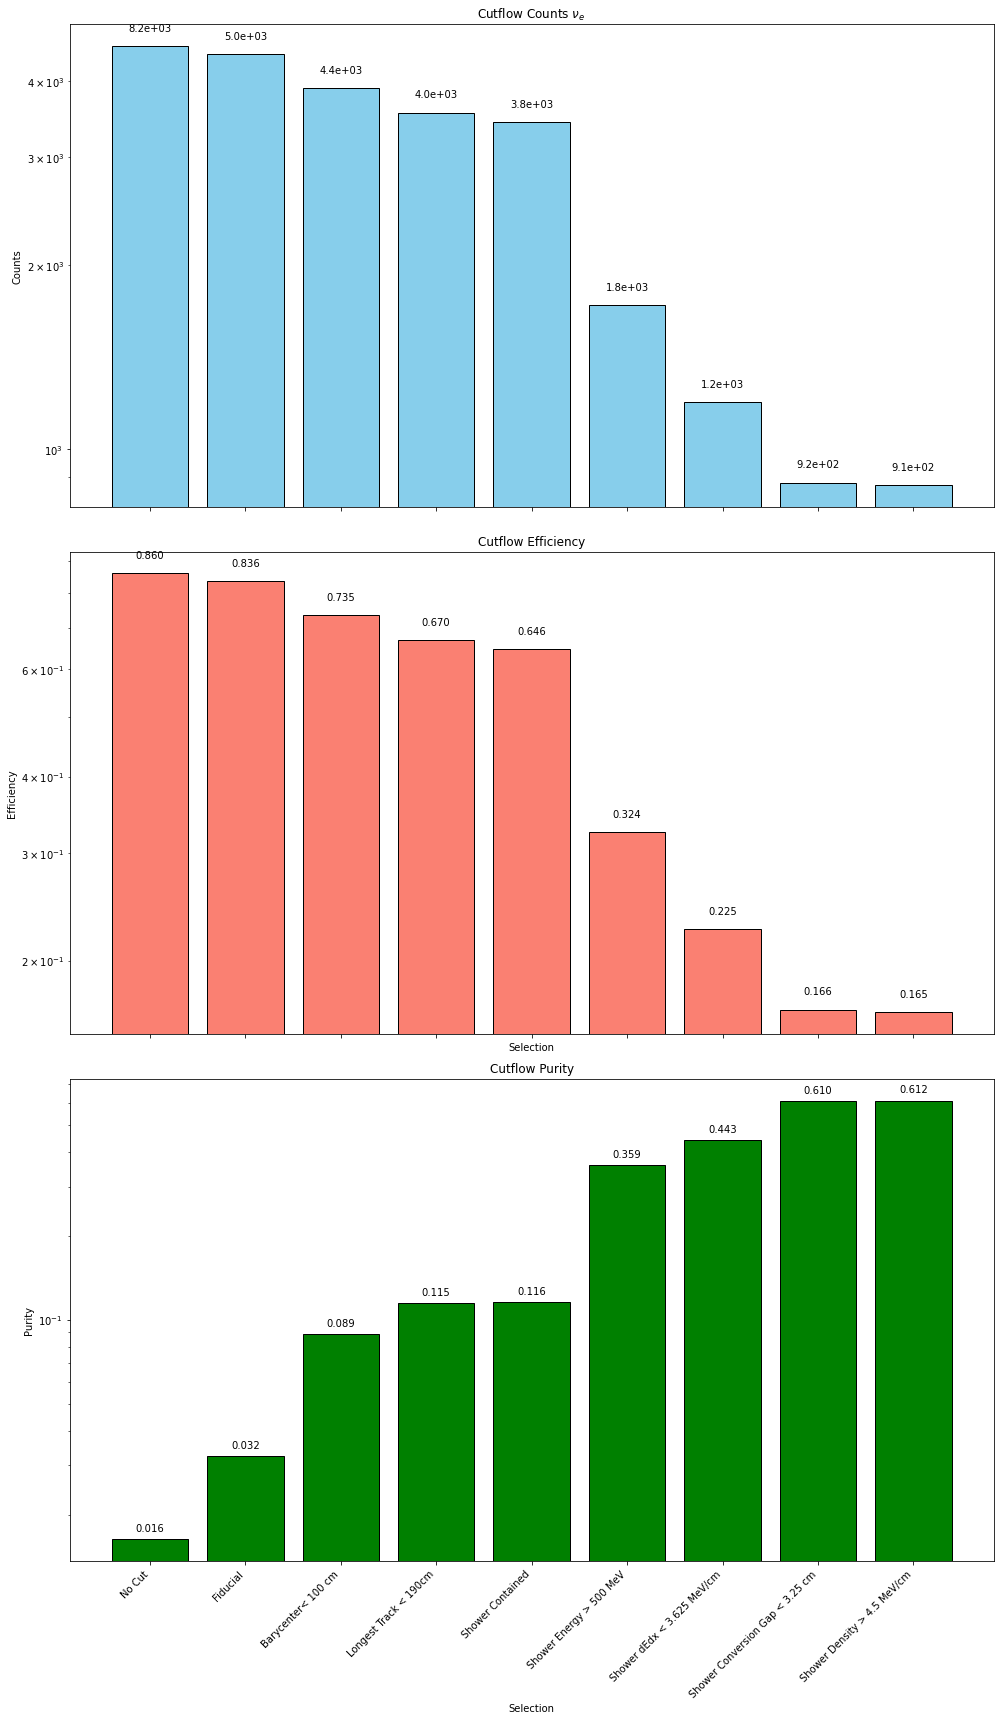

In [80]:
bin_labels = [
    "No Cut", "Fiducial", "Barycenter< 100 cm", "Longest Track < 190cm",
    "Shower Contained", "Shower Energy > 500 MeV",
    "Shower dEdx < 3.625 MeV/cm", "Shower Conversion Gap < 3.25 cm",
    "Shower Density > 4.5 MeV/cm"
]

effVar = 'rFiducial'
totalNue = s_trueE['seqNoCut_NumNuE'].integral
eff = [x.integral/totalNue for x in s_nue.values() if effVar in x.name]
eff2 = [x.integral/totalNue for x in s_nueEff.values() if effVar in x.name]
purity = [x.integral/y.integral for x, y in zip(s_nueEff.values(), s_all.values()) if effVar in x.name]

for x, y in zip(s_nueEff.values(), s_all.values()):
    if effVar in x.name:
        print(x.name, x.integral, y.integral, x.integral / y.integral)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(14, 24), sharex=True)

#Counts, top plot
bars1 = ax1.bar(range(len(eff)), [x.integral for x in s_nueEff.values() if effVar in x.name], edgecolor="black", color="skyblue")
ax1.set_yscale("log")
ax1.set_ylabel("Counts")
ax1.set_title(r"Cutflow Counts $\nu_e$")
for bar, val in zip(bars1, s_nue.values()):
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2, height*1.05, f"{val.integral:.1e}", ha='center', va='bottom')

# Efficiency, middle plot
#bars2 = ax2.bar(range(len(eff)), eff, edgecolor="black", color="salmon", alpha=0.3, label="Original Efficiency")
barsExt = ax2.bar(range(len(eff2)), eff2, edgecolor="black", color="salmon", alpha=1, label="Max Energy Slice Efficiency")
ax2.set_yscale("log")
ax2.set_xlabel("Selection")
ax2.set_ylabel("Efficiency")
ax2.set_title("Cutflow Efficiency")
#ax2.legend()
# for bar, val in zip(bars2, eff):
#     height = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2, height*1.05, f"{val:.3f}", ha='center', va='bottom')
for bar, val in zip(barsExt, eff2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height*1.05, f"{val:.3f}", ha='center', va='bottom')

# Purity, bottom plot
bars3 = ax3.bar(range(len(purity)), purity, edgecolor="black", color="green")
ax3.set_yscale("log")
ax3.set_xlabel("Selection")
ax3.set_ylabel("Purity")
ax3.set_title("Cutflow Purity")
for bar, val in zip(bars3, purity):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height*1.05, f"{val:.3f}", ha='center', va='bottom')

# Set x-axis labels
ax3.set_xticks(range(len(bin_labels)))
ax3.set_xticklabels(bin_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

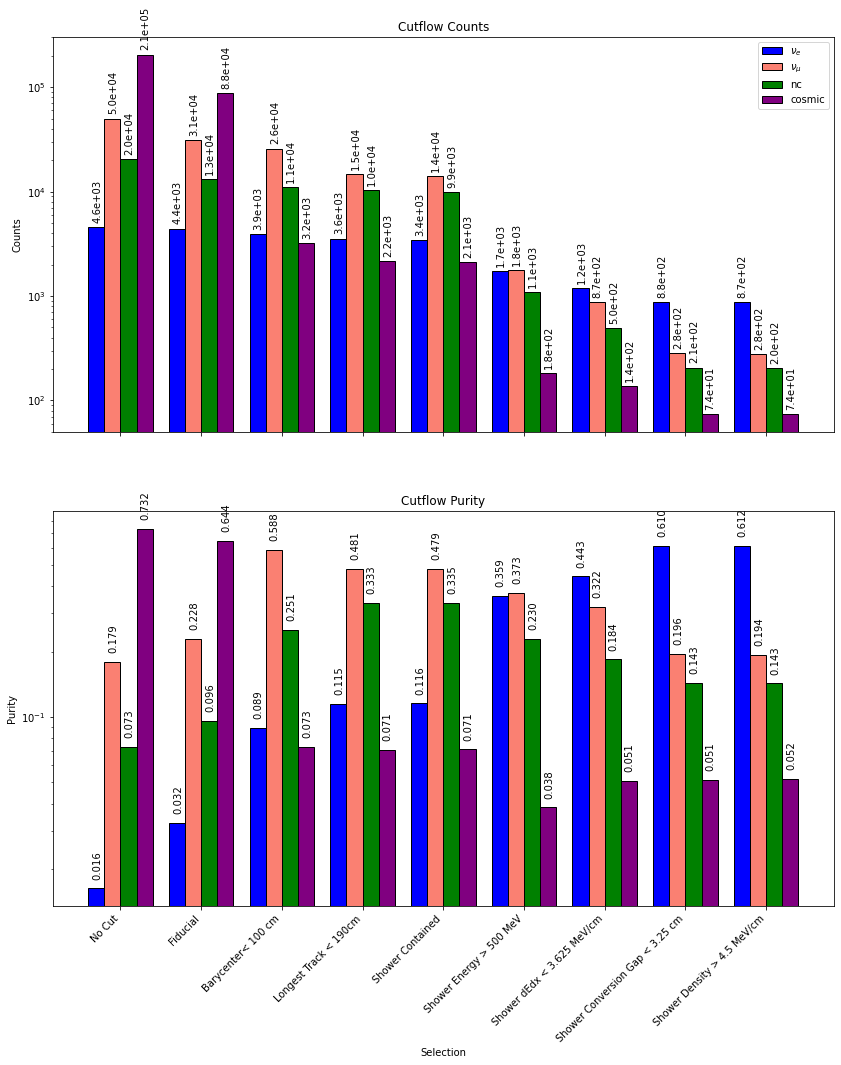

In [81]:
eff_nue = [x.integral/totalNue for x in s_nueEff.values()]
eff_numu = [x.integral/totalNue for x in s_numu.values()]
eff_nc = [x.integral/totalNue for x in s_nc.values()]
eff_cosmic = [x.integral/totalNue for x in s_cosmic.values()]

purity_nue = [x.integral/y.integral for x, y in zip(s_nueEff.values(), s_all.values()) if effVar in x.name]
purity_numu = [x.integral/y.integral for x, y in zip(s_numu.values(), s_all.values()) if effVar in x.name]
purity_nc = [x.integral/y.integral for x, y in zip(s_nc.values(), s_all.values()) if effVar in x.name]
purity_cosmic = [x.integral/y.integral for x, y in zip(s_cosmic.values(), s_all.values()) if effVar in x.name]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 16), sharex=True)

x = np.arange(len(bin_labels))   # positions for groups
width = 0.2                      # bar width

bars11 = ax1.bar(x - width*1.5, [x.integral for x in s_nueEff.values() if effVar in x.name], width, label=r"$\nu_e$", color="blue", edgecolor="black")
bars12 = ax1.bar(x - width*0.5, [x.integral for x in s_numu.values() if effVar in x.name],  width, label=r"$\nu_\mu$", color="salmon", edgecolor="black")
bars13 = ax1.bar(x + width*0.5, [x.integral for x in s_nc.values() if effVar in x.name],  width, label="nc", color="green", edgecolor="black")
bars14 = ax1.bar(x + width*1.5, [x.integral for x in s_cosmic.values() if effVar in x.name],  width, label="cosmic", color="purple", edgecolor="black")

ax1.set_yscale("log")
ax1.set_ylabel("Counts")
ax1.set_title("Cutflow Counts")
ax1.legend()

# Add bin labels
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45, ha="right")

# Print values on top of bars
for bars in [bars11, bars12, bars13, bars14]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/4, height*1.1,
                 f"{height:.1e}", ha='left', va='bottom', rotation=90)

# Bottom plot
bars21 = ax2.bar(x - width*1.5, purity_nue, width, label=r"$\nu_e$", color="blue", edgecolor="black")
bars22 = ax2.bar(x - width*0.5, purity_numu, width, label=r"$\nu_\mu$", color="salmon", edgecolor="black")
bars23 = ax2.bar(x + width*0.5, purity_nc, width, label=r"nc", color="green", edgecolor="black")
bars24 = ax2.bar(x + width*1.5, purity_cosmic, width, label=r"cosmic", color="purple", edgecolor="black")
ax2.set_yscale("log")
ax2.set_xlabel("Selection")
ax2.set_ylabel("Purity")
ax2.set_title("Cutflow Purity")
for bars in [bars21, bars22, bars23, bars24]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/4, height*1.1,
                 f"{height:.3f}", ha='left', va='bottom', rotation=90)
# # Set x-axis labels
ax2.set_xticks(range(len(bin_labels)))
ax2.set_xticklabels(bin_labels, rotation=45, ha="right")

plt.show()

In [82]:
v_seqPlots = {
    r"#nu_{e}": s_nueEff.get_dict(), 
    r"#nu_{#mu}": s_numu.get_dict(), 
    r"nc": s_nc.get_dict(), 
    r"cosmic": s_cosmic.get_dict()
}
    
v_nm1Plots = {
    r"#nu_{e}": n_nueEff.get_dict(),
    r"#nu_{#mu}": n_numu.get_dict(),
    r"nc": n_nc.get_dict(),
    r"cosmic": n_cosmic.get_dict()
}

v_seqIntPlots = {
    r"#nu_{e} CCQE": s_QE.get_dict(),
    r"#nu_{e} CCRes": s_RES.get_dict(),
    r"#nu_{e} CCDis": s_DIS.get_dict(),
    r"#nu_{e} CCCoh": s_COH.get_dict(),
    r"#nu_{e} CCMec": s_MEC.get_dict(),
    r"#nu_{e} NC": s_NC.get_dict(),
    r"#nu_{e} CCOther": s_OTHER.get_dict()
}

v_nm1IntPlots = {
    r"#nu_{e} CCQE": n_QE.get_dict(),
    r"#nu_{e} CCRes": n_RES.get_dict(),
    r"#nu_{e} CCDis": n_DIS.get_dict(),
    r"#nu_{e} CCCoh": n_COH.get_dict(),
    r"#nu_{e} CCMec": n_MEC.get_dict(),
    r"#nu_{e} NC": n_NC.get_dict(),
    r"#nu_{e} CCOther": n_OTHER.get_dict()
}

v_seqPclPlots = {
    r"e": s_ele.get_dict(),
    r"\mu": s_mu.get_dict(),
    r"p": s_pro.get_dict(),
    r"\pi^{0}": s_pi0.get_dict(),
    r"\pi^{\pm}": s_piC.get_dict(),
    r"\gamma": s_ph.get_dict(),
    r"other": s_other.get_dict()
}

v_nm1PclPlots = {
    r"e": n_ele.get_dict(),
    r"\mu": n_mu.get_dict(),
    r"p": n_pro.get_dict(),
    r"\pi^{0}": n_pi0.get_dict(),
    r"\pi^{\pm}": n_piC.get_dict(),
    r"\gamma": n_ph.get_dict(),
    r"other": n_other.get_dict()
}

labels = {"NoCut": "No Cut", "Fiducial": "Fiducial", "Barycenter": "Barycenter", "LongestTrack": "Longest Track < 190cm",
    "ShwContained": "Shower Contained", "ShowerEnergy": "Shower Energy > 500 MeV",
    "ShowerDedx": "Shower dEdx < 3.625 MeV/cm", "ShowerConversionGap": "Shower Conversion Gap < 3.25 cm",
    "ShowerDensity": "Shower Density > 4.5 MeV/cm"}

fout = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/combinedPlotsV4p3.root", "RECREATE")

n = len(labels.keys())

h_truthNue = fin.Get("fid/seqPlots/seqNoCut_NumNuE")
totalEvents = h_truthNue.GetBinContent(7)

df_seq = pd.DataFrame({
    "selection": pd.Series(index=range(n), dtype="string"),
    r"#nu_{e}": pd.Series(index=range(n), dtype="float64"),
    r"#nu_{#mu}": pd.Series(index=range(n), dtype="float64"),
    "nc": pd.Series(index=range(n), dtype="float64"),
    "cosmic": pd.Series(index=range(n), dtype="float64"),
})

df_nm1 = pd.DataFrame({
    "selection": pd.Series(index=range(n), dtype="string"),
    r"#nu_{e}": pd.Series(index=range(n), dtype="float64"),
    r"#nu_{#mu}": pd.Series(index=range(n), dtype="float64"),
    "nc": pd.Series(index=range(n), dtype="float64"),
    "cosmic": pd.Series(index=range(n), dtype="float64"),
})

colors = [r.kBlue, r.kRed, r.kGreen+2, r.kMagenta]

makeCombinedPlots(v_seqPlots, fout, "seqPlots", totalEvents, labels, pType='seq', df=df_seq, text="Sequential", colors=colors)
makeCombinedPlots(v_nm1Plots, fout, "nm1Plots", totalEvents, labels, pType='nm1', df=df_nm1, text="N-1", colors=colors)
print("making stacked background plots")
makeCombinedPlots(v_seqPlots, fout, "seqStacked", totalEvents, labels, pType='seq', stacked=True, data=s_data.get_dict(), text="Sequential", colors=[r.kBlue+2, r.kAzure+7, r.kGreen-2, r.kYellow-4])
makeCombinedPlots(v_nm1Plots, fout, "nm1Stacked", totalEvents, labels, pType='nm1', stacked=True, data=n_data.get_dict(), text="N-1", colors=[r.kBlue+2, r.kAzure+7, r.kGreen-2, r.kYellow-4])
print("making stacked interaction plots")
makeCombinedPlots(v_seqIntPlots, fout, "seqStackedInt", totalEvents, labels, pType='seq', stacked=True, text="Sequential", colors=[r.kAzure-2, r.kOrange-3, r.kRed, r.kMagenta-4, r.kGray+1, r.kViolet-6, r.kGreen-2])
makeCombinedPlots(v_nm1IntPlots, fout, "nm1StackedInt", totalEvents, labels, pType='nm1', stacked=True, text="N-1", colors=[r.kAzure-2, r.kOrange-3, r.kRed, r.kMagenta-4, r.kGray+1, r.kViolet-6, r.kGreen-2])
print("making stacked particle plots")
makeCombinedPlots(v_seqPclPlots, fout, "seqStackedPcl", totalEvents, labels, pType='seq', stacked=True, text="Sequential", colors=[r.kBlue-7, r.kAzure+1, r.kGreen-3, r.kOrange-3, r.kRed+1, r.kGray+2, r.kMagenta+2])
makeCombinedPlots(v_nm1PclPlots, fout, "nm1StackedPcl", totalEvents, labels, pType='nm1', stacked=True, text="N-1", colors=[r.kBlue-7, r.kAzure+1, r.kGreen-3, r.kOrange-3, r.kRed+1, r.kGray+2, r.kMagenta+2])

fout.Close()

making stacked background plots
making stacked interaction plots
making stacked particle plots


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [84]:
df_seq.columns = ["Selection", "nue", "numu", "nc", "cosmic"]
df_nm1.columns = ["Selection", "nue", "numu", "nc", "cosmic"]

In [85]:
df_seq['Background'] = df_seq["numu"] + df_seq["nc"] + df_seq["cosmic"]
df_seq["Total"] = df_seq["Background"] + df_seq["nue"]
df_seq['Purity'] = df_seq['nue'] / df_seq['Total']
df_seq["Delta Purity"] = df_seq["Purity"] - df_seq["Purity"].shift(1)
df_seq['Efficiency'] = df_seq['nue'] / totalEvents
df_seq["Delta Efficiency"] = df_seq["Efficiency"] - df_seq["Efficiency"].shift(1)
df_seq["S/sqrt(B)"] = df_seq["nue"] / np.sqrt(df_seq['Background'])
df_seq.round(3)

,Selection,nue,numu,nc,cosmic,Background,Total,Purity,Delta Purity,Efficiency,Delta Efficiency,S/sqrt(B)
0,No Cut,4558.245,50141.148,20368.365,160351.287,230860.800,235419.045,0.019,NaN,0.860,NaN,9.487
1,Fiducial,4431.869,31121.677,13063.206,69621.711,113806.594,118238.464,0.037,0.018,0.836,-0.024,13.137
2,Barycenter,3895.693,25790.046,10999.484,1609.487,38399.017,42294.710,0.092,0.055,0.735,-0.101,19.880
3,Longest Track < 190cm,3551.726,14826.928,10276.516,1115.770,26219.214,29770.939,0.119,0.027,0.670,-0.065,21.935
4,Shower Contained,3423.321,14196.339,9916.343,1089.966,25202.648,28625.969,0.120,0.000,0.646,-0.024,21.564
5,Shower Energy > 500 MeV,1718.182,1784.652,1098.662,80.408,2963.721,4681.904,0.367,0.247,0.324,-0.322,31.561
6,Shower dEdx < 3.625 MeV/cm,1192.938,867.831,495.943,54.240,1418.013,2610.952,0.457,0.090,0.225,-0.099,31.679
7,Shower Conversion Gap < 3.25 cm,881.674,282.846,206.547,22.429,511.822,1393.495,0.633,0.176,0.166,-0.059,38.972
8,Shower Density > 4.5 MeV/cm,872.608,276.047,203.527,22.429,502.003,1374.611,0.635,0.002,0.165,-0.002,38.946


In [86]:
df_nm1['Background'] = df_nm1["numu"] + df_nm1["nc"] + df_nm1["cosmic"]
df_nm1["Total"] = df_nm1["Background"] + df_nm1["nue"]
df_nm1['Purity'] = df_nm1['nue'] / df_nm1['Total']
df_nm1['Delta Purity'] = df_nm1['Purity'] - df_nm1['Purity'].loc[0]
df_nm1['Efficiency'] = df_nm1['nue'] / totalEvents
df_nm1["Delta Eff"] = df_nm1['Efficiency'] - df_nm1['Efficiency'].loc[0]
df_nm1["S/sqrt(B)"] = df_nm1["nue"] / np.sqrt(df_nm1['Background'])
df_nm1.round(3)

,Selection,nue,numu,nc,cosmic,Background,Total,Purity,Delta Purity,Efficiency,Delta Eff,S/sqrt(B)
0,No Cut,872.608,276.047,203.527,22.429,502.003,1374.611,0.635,0.000,0.165,0.000,38.946
1,Fiducial,877.520,362.883,262.436,30.785,656.104,1533.624,0.572,-0.063,0.166,0.001,34.259
2,Barycenter,986.976,324.692,242.757,1224.289,1791.738,2778.714,0.355,-0.280,0.186,0.022,23.317
3,Longest Track < 190cm,975.338,555.041,263.576,29.292,847.909,1823.247,0.535,-0.100,0.184,0.019,33.495
4,Shower Contained,893.013,283.933,209.579,23.560,517.072,1410.085,0.633,-0.001,0.168,0.004,39.272
5,Shower Energy > 500 MeV,1347.459,1161.116,911.830,147.219,2220.165,3567.624,0.378,-0.257,0.254,0.090,28.597
6,Shower dEdx < 3.625 MeV/cm,1240.858,595.020,475.506,39.869,1110.394,2351.252,0.528,-0.107,0.234,0.069,37.238
7,Shower Conversion Gap < 3.25 cm,1180.085,850.076,489.533,54.240,1393.848,2573.933,0.458,-0.176,0.223,0.058,31.609
8,Shower Density > 4.5 MeV/cm,881.674,282.846,206.547,22.429,511.822,1393.495,0.633,-0.002,0.166,0.002,38.972


Max Ratio 40.18272399902344 at selection 0.4000000059604645


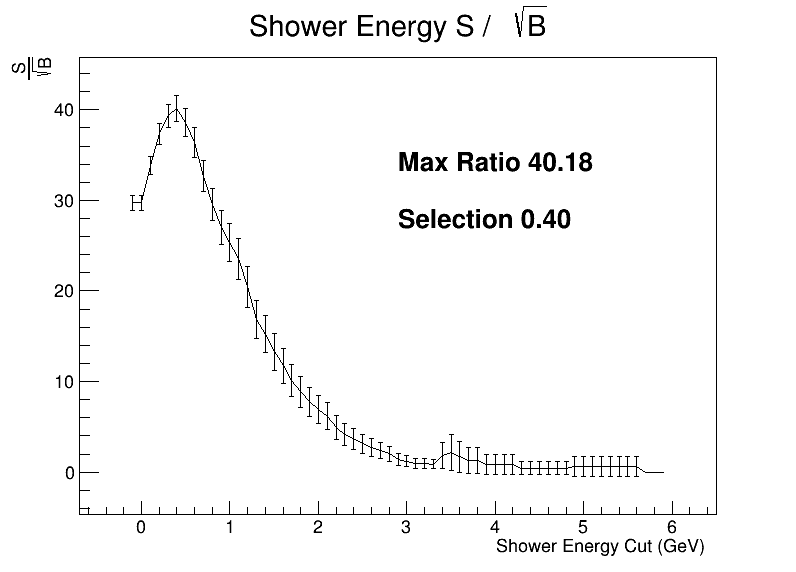

In [87]:
%jsroot off
c1 = r.TCanvas("c1", "c1", 800, 600)
h_ele = fin.Get("nue/nm1Plots/nm1ShowerEnergy_rShowerEnergy")
h_mu = fin.Get("numu/nm1Plots/nm1ShowerEnergy_rShowerEnergy")
h_nc = fin.Get("nc/nm1Plots/nm1ShowerEnergy_rShowerEnergy")
h_cosmic = fin.Get("cosmic/nm1Plots/nm1ShowerEnergy_rShowerEnergy")

h_background = h_mu.Clone()
h_background.Add(h_nc)
h_background.Add(h_cosmic)

s = []
b = []
bins = []
for ibin in range(h_ele.GetNbinsX()+1):
    s.append(h_ele.Integral(ibin, h_ele.GetNbinsX()+1))
    b.append(h_background.Integral(ibin, h_background.GetNbinsX()+1))
    bins.append(h_ele.GetXaxis().GetBinLowEdge(ibin))


s = np.array(s)
b = np.array(b)
errY = [np.sqrt(xs / xb * (1 + 0.25 * xs / xb)) for xs, xb in zip(s, b)]
errX = np.zeros(len(s))

b = np.sqrt(b)
ratio = s/b

s = arr('f', s)
b = arr('f', b)
errY = arr('f', errY)
errX = arr('f', errX)
ratio = arr('f', ratio)
bins = arr('f', bins)

h_ratioEnergy = r.TGraphErrors(len(bins), bins, ratio, errX, errY)

c1.Clear()
h_ratioEnergy.Draw()
h_ratioEnergy.SetTitle("Shower Energy S / #sqrt{B};Shower Energy Cut (GeV);#frac{S}{#sqrt{B}}")
c1.Draw()

t1 = r.TLatex()
t1.DrawLatexNDC(0.5, 0.7, f"Max Ratio {np.max(ratio):.2f}")
t2 = r.TLatex()
t2.DrawLatexNDC(0.5, 0.6, f"Selection {bins[np.argmax(ratio)]:.2f}")
print(f"Max Ratio {np.max(ratio)} at selection {bins[np.argmax(ratio)]}")

Max Ratio 38.5931282043457 at selection 180.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


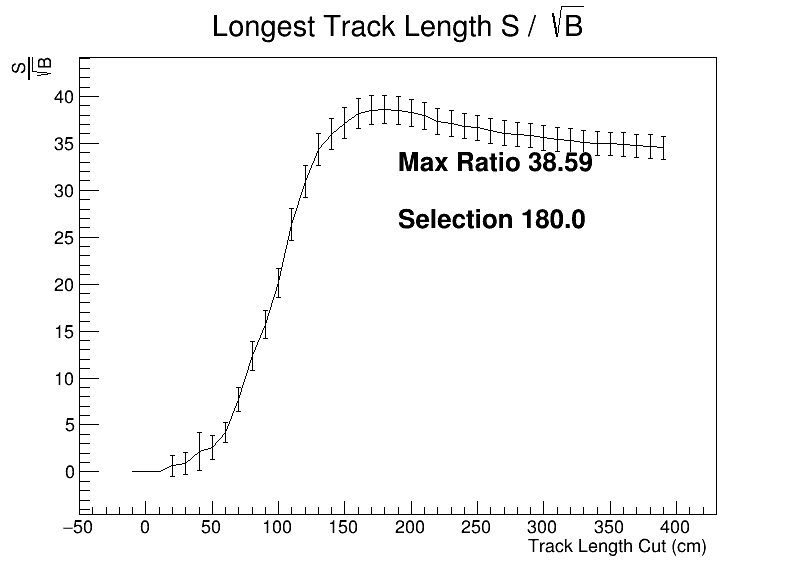

In [89]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_ele = fin.Get("nue/nm1Plots/nm1LongestTrack_rLongestTrackLength")
h_mu = fin.Get("numu/nm1Plots/nm1LongestTrack_rLongestTrackLength")
h_nc = fin.Get("nc/nm1Plots/nm1LongestTrack_rLongestTrackLength")
h_cosmic = fin.Get("cosmic/nm1Plots/nm1LongestTrack_rLongestTrackLength")

h_background = h_mu.Clone()
h_background.Add(h_nc)
h_background.Add(h_cosmic)

s = []
b = []
bins = []
for ibin in range(h_ele.GetNbinsX()+1):
    s.append(h_ele.Integral(0, ibin))
    b.append(h_background.Integral(0, ibin))
    bins.append(h_ele.GetXaxis().GetBinLowEdge(ibin))

s = np.array(s)
b = np.array(b)
errY = [
    np.sqrt(xs / xb * (1 + 0.25 * xs / xb)) if xb > 0 else np.sqrt(xs * (1 + 0.25 * xs))
    for xs, xb in zip(s, b)
]
errX = np.zeros(len(s))

b = np.sqrt(b)
ratio = [xs/xb if xb > 0 else 0 for xs, xb in zip(s, b)]

s = arr('f', s)
b = arr('f', b)
errY = arr('f', errY)
errX = arr('f', errX)
ratio = arr('f', ratio)
bins = arr('f', bins)

h_ratioEnergy = r.TGraphErrors(len(bins), bins, ratio, errX, errY)

c1.Clear()
h_ratioEnergy.Draw()
h_ratioEnergy.SetTitle("Longest Track Length S /#sqrt{B};Track Length Cut (cm);#frac{S}{#sqrt{B}}")
c1.Draw()

t1 = r.TLatex()
t1.DrawLatexNDC(0.5, 0.7, f"Max Ratio {np.max(ratio):.2f}")
t2 = r.TLatex()
t2.DrawLatexNDC(0.5, 0.6, f"Selection {bins[np.argmax(ratio)]}")

print(f"Max Ratio {np.max(ratio)} at selection {bins[np.argmax(ratio)]}")

### Make Efficiency Plots

In [138]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = n_nueEff['nm1ShowerEnergy_rShowerEnergy'].hist.Clone()
h_den = s_nueEff['seqNoCut_rShowerEnergy'].hist.Clone()
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower Energy Efficiency;Shower Energy (GeV);Efficiency")
g_eff.SetLineColor(r.kBlack)
g_eff.Draw("AP")

totalNue = s_trueE['seqNoCut_NumNuE'].integral
eff = n_nueEff['nm1ShowerEnergy_rFiducial'].integral / totalNue

purity = n_nueEff['nm1ShowerEnergy_rFiducial'].integral / n_all['nm1ShowerEnergy_rFiducial'].integral

l1 = r.TLegend(0.2, 0.7, 0.5, 0.9)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(g_eff, f"e={eff:.2f}, p={purity:.2f}", "lp")
l1.Draw()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 6 points have been skipped


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 15 points have been skipped


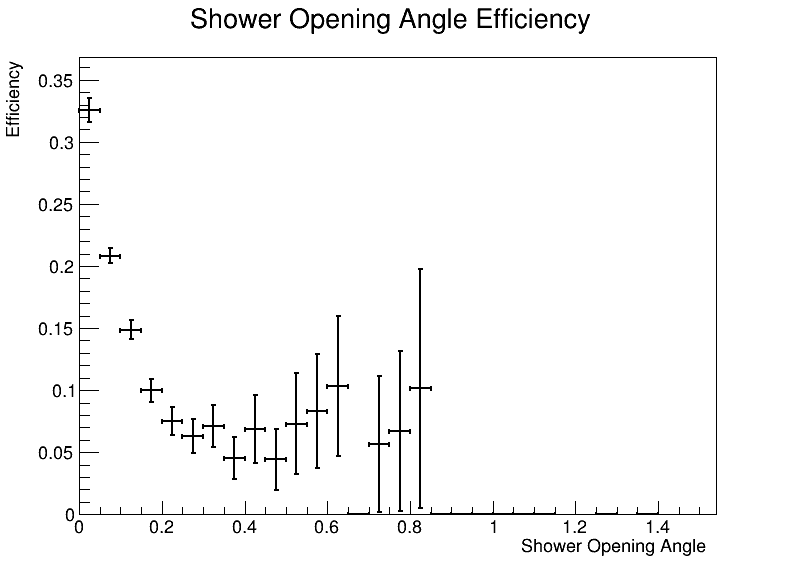

In [91]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = s_nueEff['seqShowerDensity_kShowerOpenAngle'].hist.Clone()
h_den = s_nueEff['seqNoCut_kShowerOpenAngle'].hist.Clone()
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower Opening Angle Efficiency;Shower Opening Angle;Efficiency")
g_eff.SetLineColor(r.kBlack)
g_eff.Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms


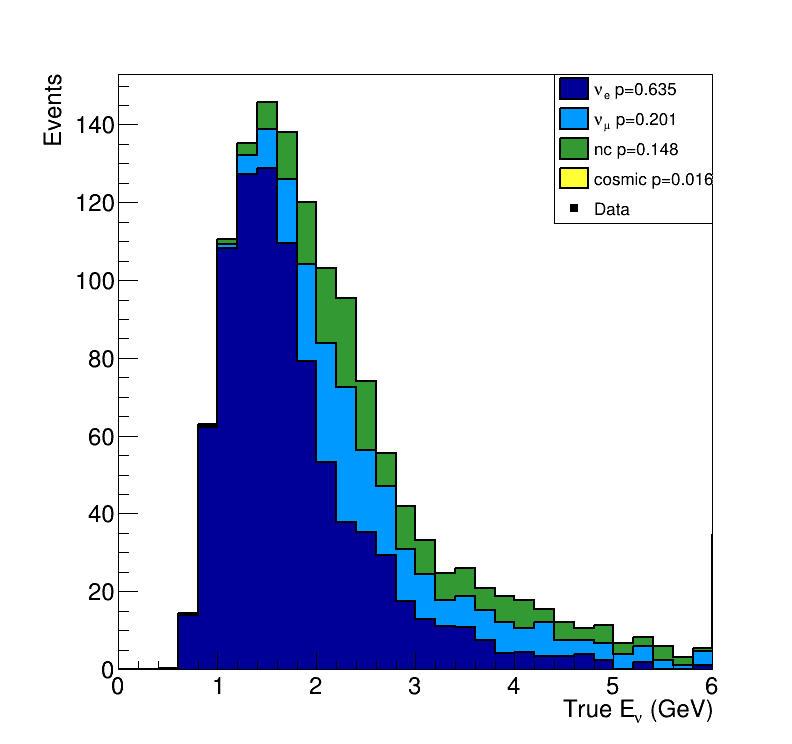

In [92]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = s_nueEff['seqShowerDensity_kShowerP'].hist.Clone()
h_num.Rebin(2)
h_den = s_nueEff['seqNoCut_kShowerP'].hist.Clone()
h_den.Rebin(2)
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower Momentum Efficiency;Shower Momentum (GeV/c);Efficiency")
g_eff.Draw("AP")
c1.Draw()



### Make stacked plots pretty

In [93]:
fPlots = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/combinedPlotsV4p3.root", "READ")
fPlots.cd("seqStacked")
fPlots.ls()

TFile**		/nashome/m/micarrig/icarus/NuE/combinedPlotsV4p3.root	
 TFile*		/nashome/m/micarrig/icarus/NuE/combinedPlotsV4p3.root	
  TDirectoryFile*		seqStacked	seqStacked
   KEY: TCanvas	seqShowerDensity_tNueEnergy;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerEnergy;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerDeDx;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerDensity;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerConversionGap;1	c1
   KEY: TCanvas	seqShowerDensity_rLongestTrackLength;1	c1
   KEY: TCanvas	seqShowerDensity_rBarycenterDeltaZ;1	c1
   KEY: TCanvas	seqShowerDensity_rBarycenterRadius;1	c1
   KEY: TCanvas	seqShowerDensity_rFiducial;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerContained;1	c1
   KEY: TCanvas	seqShowerDensity_rMuonChi2;1	c1
   KEY: TCanvas	seqShowerDensity_tInteractionMode;1	c1
   KEY: TCanvas	seqShowerDensity_tNeutrinoType;1	c1
   KEY: TCanvas	seqShowerDensity_rSubleadingShowerEnergy;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerEResidual;1	c1
   KEY: TCanvas	seqShow

In [94]:
%jsroot off
c = fPlots.Get("seqStacked/seqShowerDensity_tNueEnergy")
c.SetLeftMargin(0.15)

rebinFactor = 2
# Loop over the objects in the canvas and rebin TH1s
objects = c.GetListOfPrimitives()
for obj in objects:
    if obj.InheritsFrom("TH1"):
        obj.Rebin(rebinFactor)
        obj.SetMaximum(8000)
    elif obj.InheritsFrom("THStack"):
        # For THStack, we need to rebin the histograms in the stack
        stack_hists = obj.GetHists()
        for hist in stack_hists:
            hist.Rebin(rebinFactor)
            hist.SetMaximum(8000)
c.Update()
c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/trueNueEnergy.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/trueNueEnergy.png has been created


In [95]:
c.Draw()

In [96]:
c = fPlots.Get("seqStackedInt/seqShowerDensity_tNueEnergy")
c.SetLeftMargin(0.15)

rebinFactor = 2
# Loop over the objects in the canvas and rebin TH1s
objects = c.GetListOfPrimitives()
for obj in objects:
    if obj.InheritsFrom("TH1"):
        obj.Rebin(rebinFactor)
        obj.SetMaximum(8000)
    elif obj.InheritsFrom("THStack"):
        # For THStack, we need to rebin the histograms in the stack
        stack_hists = obj.GetHists()
        for hist in stack_hists:
            hist.Rebin(rebinFactor)
            hist.SetMaximum(8000)
c.Update()
c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/trueNueEnergyInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/trueNueEnergyInt.png has been created


In [97]:
%jsroot on
c = fPlots.Get('nm1Stacked/nm1ShowerEnergy_rShowerEnergy')

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())


upper = c.GetPrimitive("pad1")
upper.cd()
hstack = upper.GetPrimitive("h_stack")
#hstack.Draw("same a")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.SetMaximum(maxY*1.7)
hstack.SetMinimum(0)
hstack.GetXaxis().SetRangeUser(0, 3.0)  # Set x-axis range from 0 to 3 GeV
upper.Modified()
upper.Update()
l = r.TLine(0.5, 0, 0.5, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

lower = c.GetPrimitive("pad2")
lower.cd()
h_ratio = lower.GetPrimitive("h_ratio")
maxX = h_ratio.GetXaxis().GetXmax()
l2 = r.TLine(0, 1, maxX, 1)
l2.SetLineStyle(2)
l2.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergy.png")

pad1
pad2


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergy.png has been created


In [98]:
c.Draw()

In [99]:
c = fPlots.Get('nm1StackedInt/nm1ShowerEnergy_rShowerEnergy')
c.SetLeftMargin(0.15)

hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0.5, 0, 0.5, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyInt.png has been created


In [100]:
c = fPlots.Get('nm1Stacked/nm1ShowerDedx_rShowerDeDx')

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())


upper = c.GetPrimitive("pad1")
upper.cd()
hstack = upper.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.SetMaximum(maxY*1.3)
hstack.SetMinimum(0)
upper.Modified()
upper.Update()
l = r.TLine(3.625, 0, 3.625, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

lower = c.GetPrimitive("pad2")
lower.cd()
h_ratio = lower.GetPrimitive("h_ratio")
maxX = h_ratio.GetXaxis().GetXmax()
l2 = r.TLine(0, 1, maxX, 1)
l2.SetLineStyle(2)
l2.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerDeDx.png")

pad1
pad2


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerDeDx.png has been created


In [101]:
c.Draw()

In [102]:
c = fPlots.Get('nm1StackedInt/nm1ShowerDedx_rShowerDeDx')
c.SetLeftMargin(0.15)

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())

hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(3.625, 0, 3.625, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerDeDxInt.png")

TFrame
h_stack

TPave


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerDeDxInt.png has been created


In [103]:
c = fPlots.Get('seqStacked/seqShowerDensity_rShowerEResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEResidual.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEResidual.png has been created


In [104]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rShowerEResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEResidualInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEResidualInt.png has been created


In [107]:
c = fPlots.Get('nm1Stacked/nm1LongestTrack_rLongestTrackLength')

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())


upper = c.GetPrimitive("pad1")
upper.cd()
hstack = upper.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.SetMaximum(maxY*1.7)
hstack.SetMinimum(0)
upper.Modified()
upper.Update()
l = r.TLine(190, 0, 190, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

lower = c.GetPrimitive("pad2")
lower.cd()
h_ratio = lower.GetPrimitive("h_ratio")
maxX = h_ratio.GetXaxis().GetXmax()
l2 = r.TLine(0, 1, maxX, 1)
l2.SetLineStyle(2)
l2.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoLongestTrack.png")

pad1
pad2


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoLongestTrack.png has been created


In [108]:
c = fPlots.Get('nm1StackedInt/nm1LongestTrack_rLongestTrackLength')
c.SetLeftMargin(0.15)

hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(190, 0, 190, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoLongestTrackInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoLongestTrackInt.png has been created


In [39]:
c = fPlots.Get('seqStacked/seqShowerDensity_rShowerLenResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")
c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerLenResidual.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerLenResidual.png has been created


In [40]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rShowerLenResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerLenResidualInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerLenResidualInt.png has been created


In [41]:
c = fPlots.Get('seqStacked/seqShowerDensity_rVertexResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoVertexResidual.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoVertexResidual.png has been created


In [42]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rVertexResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoVertexResidualInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoVertexResidualInt.png has been created


In [111]:
c = fPlots.Get('seqStacked/seqShowerDensity_rShowerEnergy')

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())


upper = c.GetPrimitive("pad1")
upper.cd()
hstack = upper.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.SetMaximum(maxY*1.4)
hstack.SetMinimum(0)
hstack.GetXaxis().SetRangeUser(0, 3)
upper.Modified()
upper.Update()
l = r.TLine(0.5, 0, 0.5, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

lower = c.GetPrimitive("pad2")
lower.cd()
h_ratio = lower.GetPrimitive("h_ratio")
maxX = h_ratio.GetXaxis().GetXmax()
l2 = r.TLine(0, 1, maxX, 1)
l2.SetLineStyle(2)
l2.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyFull.png")

pad1
pad2


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyFull.png has been created


In [112]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rShowerEnergy')
c.SetLeftMargin(0.15)

hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.GetXaxis().SetRangeUser(0, 3)
c.Modified()
c.Update()
l = r.TLine(0.5, 0, 0.5, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyIntFull.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyIntFull.png has been created


In [110]:
c.Draw()

### Check east vs west cryo

In [45]:
f_E = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcV3West/mc.root", "READ") #note had these backwards in cut, cut not fixed
f_W = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcV3East/mc.root", "READ")

s_e_all = getHistList(f_E, "allEvents/seqPlots")
s_e_nueEff = getHistList(f_E, "nueEff/seqPlots", skip='MaxShowerEnergySlice')
n_e_all = getHistList(f_E, "allEvents/nm1Plots")
n_e_nueEff = getHistList(f_E, "nueEff/nm1Plots", skip='MaxShowerEnergySlice')

s_w_all = getHistList(f_W, "allEvents/seqPlots")
s_w_nueEff = getHistList(f_W, "nueEff/seqPlots", skip='MaxShowerEnergySlice')
n_w_all = getHistList(f_W, "allEvents/nm1Plots")
n_w_nueEff = getHistList(f_W, "nueEff/nm1Plots", skip='MaxShowerEnergySlice')

In [541]:
s_EW = {
    'East': s_e_all.get_dict(),
    'West': s_w_all.get_dict(),
}

s_nue_EW = {
    'East': s_e_nueEff.get_dict(),
    'West': s_w_nueEff.get_dict(),
}

n_EW = {
    'East': n_e_all.get_dict(),
    'West': n_w_all.get_dict(),
}

n_nue_EW = {
    'East': n_e_nueEff.get_dict(),
    'West': n_w_nueEff.get_dict(),
}

labels = {"NoCut": "No Cut", "Fiducial": "Fiducial", "Barycenter": "Barycenter", "LongestTrack": "Longest Track < 190cm",
    "ShwContained": "Shower Contained", "ShowerEnergy": "Shower Energy > 500 MeV",
    "ShowerDedx": "Shower dEdx < 3.625 MeV/cm", "ShowerConversionGap": "Shower Conversion Gap < 3.25 cm",
    "ShowerDensity": "Shower Density > 4.5 MeV/cm"}

fout = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/compareEW.root", "RECREATE")

n = len(labels.keys())

h_truthNue = fin.Get("fid/seqPlots/seqNoCut_NumNuE")
totalEvents = h_truthNue.GetBinContent(7)

makeCombinedPlots(s_EW, fout, "seqPlotsAll", totalEvents, labels, pType='seq', df=df_seq, text="Sequential", data=True, colors=[r.kBlue, r.kRed])
makeCombinedPlots(s_nue_EW, fout, "seqPlotsNue", totalEvents, labels, pType='seq', df=df_seq, text="Sequential", data=True, colors=[r.kBlue, r.kRed])
makeCombinedPlots(n_EW, fout, "nm1PlotsAll", totalEvents, labels, pType='nm1', df=df_seq, text="Sequential", data=True, colors=[r.kBlue, r.kRed])
makeCombinedPlots(n_nue_EW, fout, "nm1PlotsNue", totalEvents, labels, pType='nm1', df=df_seq, text="Sequential", data=True, colors=[r.kBlue, r.kRed])

fout.Close()


### Check anti electron neutrino concentration in RHC vs FHC

In [33]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcRHC/mc.root")

c1 = r.TCanvas("c1", "c1", 1000, 700)

%jsroot off

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


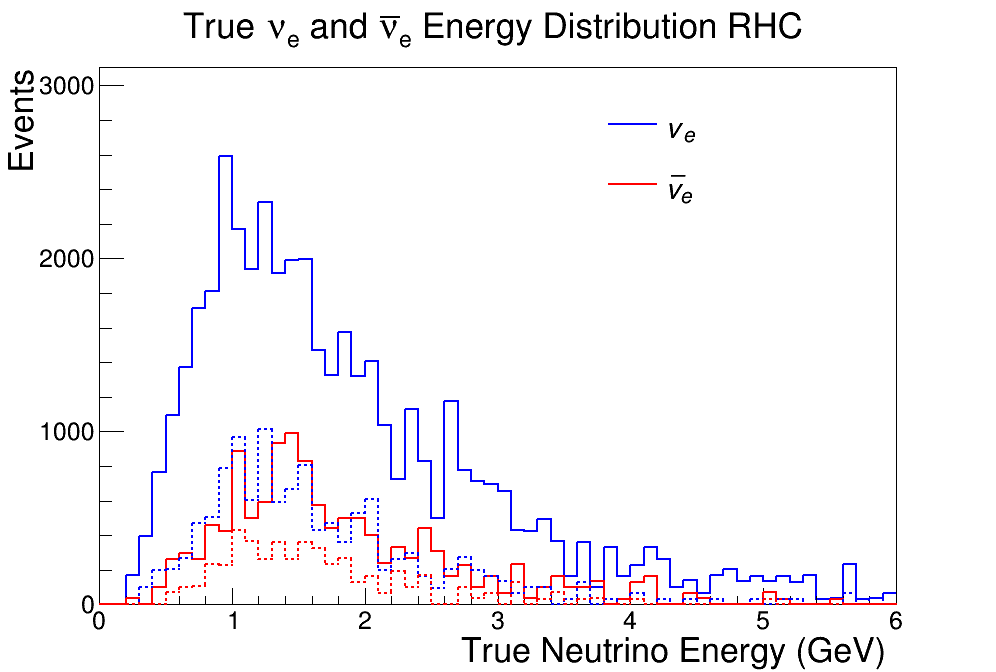

In [34]:
h_nue = fin.Get("nueP/seqPlots/seqNoCut_tNueEnergy")
h_anue = fin.Get("nueA/seqPlots/seqNoCut_tNueEnergy")

# h_nueCut = fin.Get("nueP/seqPlots/seqShowerDensity_tNueEnergy")
# h_anueCut = fin.Get("nueA/seqPlots/seqShowerDensity_tNueEnergy")
h_nueCut = fin.Get("nueP/nm1Plots/nm1ShowerEnergy_tNueEnergy")
h_anueCut = fin.Get("nueA/nm1Plots/nm1ShowerEnergy_tNueEnergy")

h_nue.SetLineColor(r.kBlue)
h_nue.SetLineWidth(2)
h_anue.SetLineColor(r.kRed)
h_anue.SetLineWidth(2)

max_hist = max(h_nue.GetMaximum(), h_anue.GetMaximum())
h_nue.SetMaximum(max_hist * 1.2)
h_nue.SetMinimum(0)

l1 = r.TLegend(0.6, 0.68, 0.88, 0.86)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(h_nue, r"\nu_e", "l")
l1.AddEntry(h_anue, r"\bar{\nu}_e", "l")

h_nue.SetTitle("True #nu_{e} and #bar{#nu}_{e} Energy Distribution RHC;True Neutrino Energy (GeV);Events")
h_nue.Draw("hist")
h_anue.Draw("hist same")

h_nueCut.SetLineColor(r.kBlue)
h_nueCut.SetLineWidth(2)
h_nueCut.SetLineStyle(2)
h_anueCut.SetLineColor(r.kRed)
h_anueCut.SetLineWidth(2)
h_anueCut.SetLineStyle(2)

h_nueCut.Draw("same hist")
h_anueCut.Draw("same hist")

l1.Draw()

# gEff_nue = r.TGraphAsymmErrors(h_nueCut, h_nue)
# gEff_anue = r.TGraphAsymmErrors(h_anueCut, h_anue)

# rightmax = 1.0
# leftmax = max_hist if max_hist else 1.0
# scale = leftmax / rightmax if rightmax else 1.0

# gEff_nue_scaled = gEff_nue.Clone("gEff_nue_scaled")
# gEff_anue_scaled = gEff_anue.Clone("gEff_anue_scaled")

# for i in range(gEff_nue_scaled.GetN()):
#     gEff_nue_scaled.SetPoint(i, gEff_nue_scaled.GetX()[i], gEff_nue_scaled.GetY()[i] * scale)
#     gEff_nue_scaled.SetPointEYlow(i, gEff_nue_scaled.GetErrorYlow(i) * scale)
#     gEff_nue_scaled.SetPointEYhigh(i, gEff_nue_scaled.GetErrorYhigh(i) * scale)

# for i in range(gEff_anue_scaled.GetN()):
#     gEff_anue_scaled.SetPoint(i, gEff_anue_scaled.GetX()[i], gEff_anue_scaled.GetY()[i] * scale)
#     gEff_anue_scaled.SetPointEYlow(i, gEff_anue_scaled.GetErrorYlow(i) * scale)
#     gEff_anue_scaled.SetPointEYhigh(i, gEff_anue_scaled.GetErrorYhigh(i) * scale)

# gEff_nue_scaled.SetMarkerStyle(20)
# gEff_nue_scaled.SetMarkerColor(r.kBlue)
# gEff_nue_scaled.SetLineColor(r.kBlue)
# gEff_anue_scaled.SetMarkerStyle(21)
# gEff_anue_scaled.SetMarkerColor(r.kRed)
# gEff_anue_scaled.SetLineColor(r.kRed)

# gEff_nue_scaled.Draw("P same")
# gEff_anue_scaled.Draw("P same")

# r.gPad.Update()
# axis = r.TGaxis(r.gPad.GetUxmax(), r.gPad.GetUymin(), r.gPad.GetUxmax(), r.gPad.GetUymax(), 0.0, rightmax, 510, "+L")
# axis.SetTitle("Efficiency")
# axis.SetTitleOffset(1.4)
# axis.SetLabelColor(r.kBlack)
# axis.SetTitleColor(r.kBlack)
# axis.Draw()

# l1.AddEntry(gEff_nue_scaled, r"\nu_e efficiency", "lp")
# l1.AddEntry(gEff_anue_scaled, r"\bar{\nu}_e efficiency", "lp")
# l1.Draw()

# r.gPad.RedrawAxis()

c1.Draw()

Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped


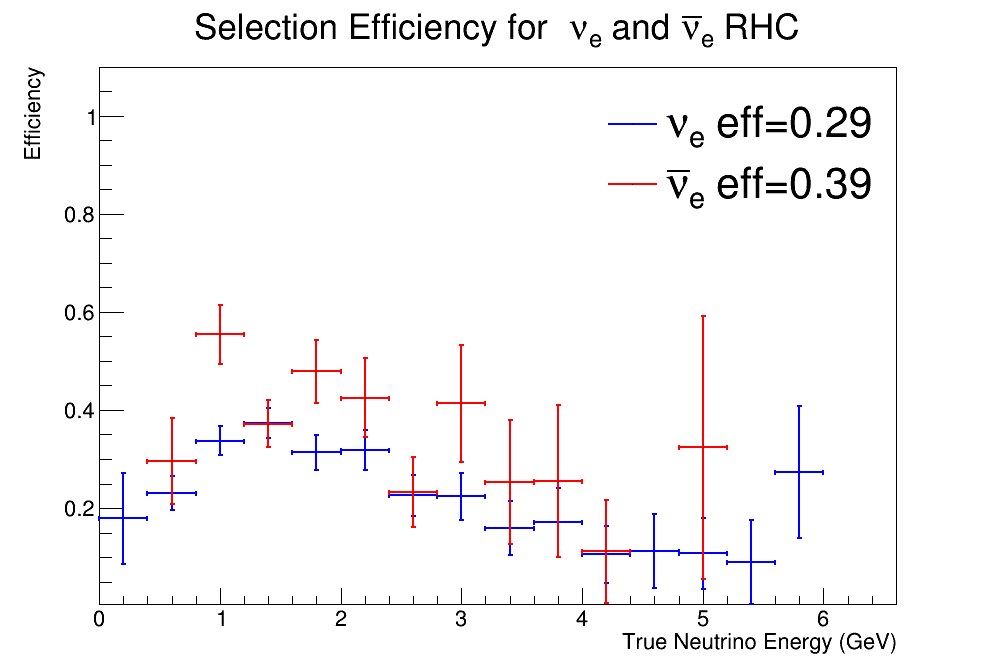

In [28]:
c_nueCut = h_nueCut.Clone()
c_nue = h_nue.Clone()

c_anueCut = h_anueCut.Clone()
c_anue = h_anue.Clone()

eff_nue = h_nueCut.Integral() / h_nue.Integral()
eff_anue = h_anueCut.Integral() / h_anue.Integral()

rebin=4
c_nueCut.Rebin(rebin)
c_nue.Rebin(rebin)
c_anueCut.Rebin(rebin)
c_anue.Rebin(rebin)

gEff_nue = r.TGraphAsymmErrors(c_nueCut, c_nue)
gEff_anue = r.TGraphAsymmErrors(c_anueCut, c_anue)

gEff_nue.SetMaximum(1.1)
gEff_nue.SetTitle("Selection Efficiency for #nu_{e} and #bar{#nu}_{e} RHC; True Neutrino Energy (GeV); Efficiency")

gEff_nue.SetLineColor(r.kBlue)
gEff_anue.SetLineColor(r.kRed)

l1 = r.TLegend(0.6, 0.68, 0.88, 0.86)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(gEff_nue, f"#nu_{{e}} eff={eff_nue:.2f}", "lp")
l1.AddEntry(gEff_anue, f"#bar{{#nu}}_{{e}} eff={eff_anue:.2f}", "lp")

gEff_nue.Draw("AP")
gEff_anue.Draw("P same")
l1.Draw()

c1.Draw()

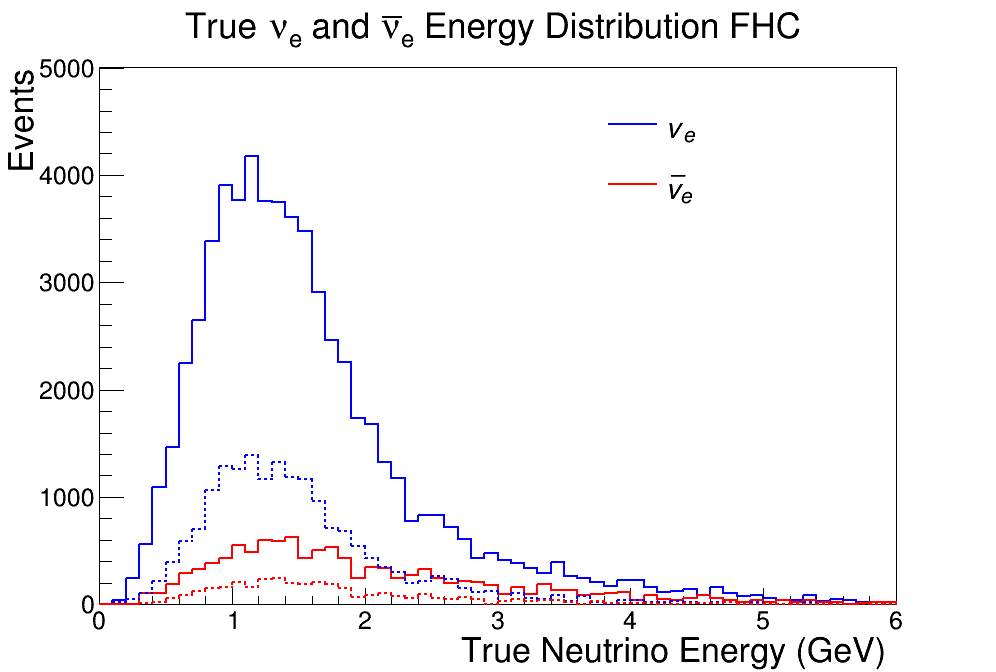

In [32]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcV3/mc.root")

h_nue = fin.Get("nueP/seqPlots/seqNoCut_tNueEnergy")
h_anue = fin.Get("nueA/seqPlots/seqNoCut_tNueEnergy")

# h_nueCut = fin.Get("nueP/seqPlots/seqShowerDensity_tNueEnergy")
# h_anueCut = fin.Get("nueA/seqPlots/seqShowerDensity_tNueEnergy")
h_nueCut = fin.Get("nueP/nm1Plots/nm1ShowerEnergy_tNueEnergy")
h_anueCut = fin.Get("nueA/nm1Plots/nm1ShowerEnergy_tNueEnergy")

h_nue.SetLineColor(r.kBlue)
h_nue.SetLineWidth(2)
h_anue.SetLineColor(r.kRed)
h_anue.SetLineWidth(2)

h_nueCut.SetLineColor(r.kBlue)
h_nueCut.SetLineWidth(2)
h_nueCut.SetLineStyle(2)
h_anueCut.SetLineColor(r.kRed)
h_anueCut.SetLineWidth(2)
h_anueCut.SetLineStyle(2)

max_hist = max(h_nue.GetMaximum(), h_anue.GetMaximum())
h_nue.SetMaximum(max_hist * 1.2)
h_nue.SetMinimum(0)

l1 = r.TLegend(0.6, 0.68, 0.88, 0.86)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(h_nue, r"\nu_e", "l")
l1.AddEntry(h_anue, r"\bar{\nu}_e", "l")

h_nue.SetTitle("True #nu_{e} and #bar{#nu}_{e} Energy Distribution FHC;True Neutrino Energy (GeV);Events")
h_nue.Draw("hist")
h_anue.Draw("hist same")

h_nueCut.Draw("hist same")
h_anueCut.Draw("hist same")

l1.Draw()

c1.Draw()

Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms


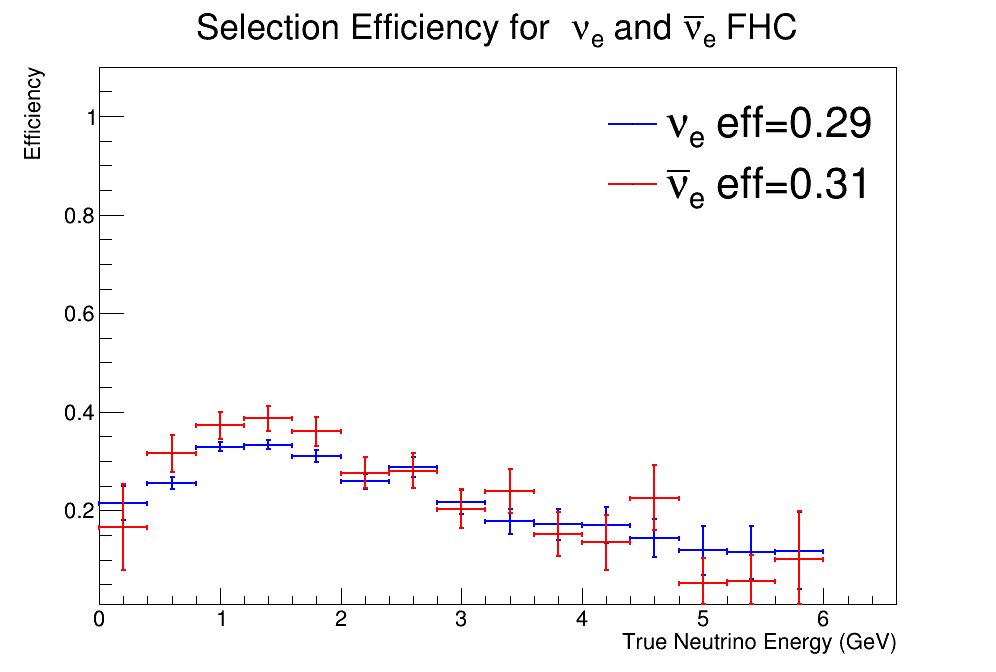

In [30]:
c_nueCut = h_nueCut.Clone()
c_nue = h_nue.Clone()

c_anueCut = h_anueCut.Clone()
c_anue = h_anue.Clone()

eff_nue = h_nueCut.Integral() / h_nue.Integral()
eff_anue = h_anueCut.Integral() / h_anue.Integral()

rebin=4
c_nueCut.Rebin(rebin)
c_nue.Rebin(rebin)
c_anueCut.Rebin(rebin)
c_anue.Rebin(rebin)

gEff_nue = r.TGraphAsymmErrors(c_nueCut, c_nue)
gEff_anue = r.TGraphAsymmErrors(c_anueCut, c_anue)

gEff_nue.SetMaximum(1.1)
gEff_nue.SetTitle("Selection Efficiency for #nu_{e} and #bar{#nu}_{e} FHC; True Neutrino Energy (GeV); Efficiency")

gEff_nue.SetLineColor(r.kBlue)
gEff_anue.SetLineColor(r.kRed)

l1 = r.TLegend(0.6, 0.68, 0.88, 0.86)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(gEff_nue, f"#nu_{{e}} eff={eff_nue:.2f}", "lp")
l1.AddEntry(gEff_anue, f"#bar{{#nu}}_{{e}} eff={eff_anue:.2f}", "lp")

gEff_nue.Draw("AP")
gEff_anue.Draw("P same")
l1.Draw()

c1.Draw()

### Check efficiency for CVN

In [145]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/cvnMC/mc.root")

scale_mc = 1.0

In [146]:
s_nue = getHistList(fin, "nue/seqPlots", scale=scale_mc)
s_numu = getHistList(fin, "numu/seqPlots", scale=scale_mc)
s_nc = getHistList(fin, "nc/seqPlots", scale=scale_mc)
s_cosmic = getHistList(fin, "cosmic/seqPlots", scale=scale_mc)
s_all = getHistList(fin, "allEvents/seqPlots", skip="MaxShowerEnergySlice", scale=scale_mc)
s_trueE = getHistList(fin, "fid/seqPlots", scale=scale_mc)
s_nueEff = getHistList(fin, "nueEff/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)


n_nue = getHistList(fin, "nue/nm1Plots", scale=scale_mc)
n_numu = getHistList(fin, "numu/nm1Plots", scale=scale_mc)
n_nc = getHistList(fin, "nc/nm1Plots", scale=scale_mc)
n_cosmic = getHistList(fin, "cosmic/nm1Plots", scale=scale_mc)
n_all = getHistList(fin, "allEvents/nm1Plots", skip="MaxShowerEnergySlice", scale=scale_mc)
n_trueE = getHistList(fin, "fid/nm1Plots", scale=scale_mc)
n_nueEff = getHistList(fin, "nueEff/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)

In [147]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = n_nueEff['nm1CVNNue_rShowerEnergy'].hist.Clone()
h_den = s_nueEff['seqNoCut_rShowerEnergy'].hist.Clone()
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower Energy Efficiency;Shower Energy (GeV);Efficiency")
g_eff.SetLineColor(r.kBlack)
g_eff.SetMarkerStyle(20)
g_eff.SetMarkerColorAlpha(r.kBlack, 0.5)
g_eff.Draw("AP")

h_num_cvn = s_nueEff['seqShowerDensity_rShowerEnergy'].hist.Clone()
h_den_cvn = s_nueEff['seqNoCut_rShowerEnergy'].hist.Clone()
g_eff_cvn = r.TGraphAsymmErrors(h_num_cvn, h_den_cvn)
g_eff_cvn.SetTitle("Shower Energy Efficiency;Shower Energy (GeV);Efficiency")
g_eff_cvn.SetLineColor(r.kRed)
g_eff_cvn.SetMarkerStyle(21)
g_eff_cvn.SetMarkerColorAlpha(r.kRed, 0.5)
g_eff_cvn.Draw("P SAME")

totalNue = s_trueE['seqNoCut_NumNuE'].integral
effCVN = s_nueEff['seqShowerDensity_rFiducial'].integral / totalNue
eff = n_nueEff['nm1CVNNue_rFiducial'].integral / totalNue

purity = n_nueEff['nm1CVNNue_rFiducial'].integral / n_all['nm1CVNNue_rFiducial'].integral
purityCVN = s_nueEff['seqShowerDensity_rFiducial'].integral / s_all['seqShowerDensity_rFiducial'].integral

print(purity, purityCVN)

l1 = r.TLegend(0.2, 0.7, 0.5, 0.9)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(g_eff_cvn, f"CVN: > 0.85, e={effCVN:.2f}, p={purityCVN:.2f}", "lp")
l1.AddEntry(g_eff, f"No CVN, e={eff:.2f}, p={purity:.2f}", "lp")
l1.Draw()

c1.Draw()

totalNue

0.4775517110693264 0.8557473039509162


79030.05065491909

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 29 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 29 points have been skipped
